# Project Tasks

In the first two assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should try both combining the profiles with activities and using each data type independently.
* Implement different models of your choice for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier to predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session.

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially at the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [1]:
import pandas as pd
import re

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Mutational catalogs and activities - WGS data

In [3]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

Mutation type Trinucleotide  Biliary-AdenoCA::SP117655  \
0           C>A           ACA                        269   
1           C>A           ACC                        148   

   Biliary-AdenoCA::SP117556  Biliary-AdenoCA::SP117627  \
0                        114                        105   
1                         56                         71   

   Biliary-AdenoCA::SP117775  Biliary-AdenoCA::SP117332  \
0                        217                         52   
1                        123                         36   

   Biliary-AdenoCA::SP117712  Biliary-AdenoCA::SP117017  \
0                        192                         54   
1                        139                         54   

   Biliary-AdenoCA::SP117031  ...  Uterus-AdenoCA::SP94540  \
0                        196  ...                      117   
1                        102  ...                       90   

   Uterus-AdenoCA::SP95222  Uterus-AdenoCA::SP89389  Uterus-AdenoCA::SP90503  \
0                      233                       94                      114   
1                      167                       59                       64   

   Uterus-AdenoCA::SP92460  Uterus-AdenoCA::SP92931  Uterus-AdenoCA::SP91265  \
0                      257                      139                      404   
1                      268                       75                      255   

   Uterus-AdenoCA::SP89909  Uterus-AdenoCA::SP90629  Uterus-AdenoCA::SP95550  
0                       97                      250                      170  
1                       78                      188                      137  

[2 rows x 2782 columns]

Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [4]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

Cancer Types Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  SBS5  SBS6  \
0  Biliary-AdenoCA     SP117655     0.968  1496  1296     0     0  1825     0   
1  Biliary-AdenoCA     SP117556     0.963   985     0     0     0   922     0   

   SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  SBS58  SBS59  \
0      0  ...      0      0      0      0      0      0      0      0      0   
1      0  ...      0      0      0      0      0      0      0      0      0   

   SBS60  
0      0  
1      0  

[2 rows x 68 columns]

In [5]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

Mutation type Trinucleotide  ALL::PD4020a  ALL::SJBALL011_D  \
0           C>A           ACA            35                 9   
1           C>A           ACC            16                 2   

   ALL::SJBALL012_D  ALL::SJBALL020013_D1  ALL::SJBALL020422_D1  \
0                 2                     7                     5   
1                 4                    10                     5   

   ALL::SJBALL020579_D1  ALL::SJBALL020589_D1  ALL::SJBALL020625_D1  ...  \
0                     7                     3                     5  ...   
1                     9                     1                     2  ...   

   Stomach-AdenoCa::pfg316T  Stomach-AdenoCa::pfg317T  \
0                       133                       185   
1                        48                        70   

   Stomach-AdenoCa::pfg344T  Stomach-AdenoCa::pfg373T  \
0                       202                       185   
1                       126                        88   

   Stomach-AdenoCa::pfg375T  Stomach-AdenoCa::pfg378T  \
0                        96                       134   
1                        35                        54   

   Stomach-AdenoCa::pfg398T  Stomach-AdenoCa::pfg413T  \
0                        12                       279   
1                        16                       112   

   Stomach-AdenoCa::pfg416T  Stomach-AdenoCa::pfg424T  
0                        75                       135  
1                        31                        91  

[2 rows x 1867 columns]

In [5]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

Cancer Types Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  SBS5  SBS6  \
0          ALL      PD4020a     0.995   208  3006     0     0   365     0   
1          ALL  SJBALL011_D     0.905    66     0     0     0   144     0   

   SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  SBS58  SBS59  \
0      0  ...      0      0      0      0      0      0      0      0      0   
1      0  ...      0      0      0      0      0      0      0      0      0   

   SBS60  
0      0  
1      0  

[2 rows x 68 columns]

## Mutational catalogs - WES data

In [6]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

Mutation type Trinucleotide  AML::TCGA-AB-2802-03B-01W-0728-08  \
0           C>A           ACA                                  0   
1           C>A           ACC                                  0   

   AML::TCGA-AB-2803-03B-01W-0728-08  AML::TCGA-AB-2804-03B-01W-0728-08  \
0                                  0                                  0   
1                                  2                                  0   

   AML::TCGA-AB-2805-03B-01W-0728-08  AML::TCGA-AB-2806-03B-01W-0728-08  \
0                                  0                                  4   
1                                  0                                  0   

   AML::TCGA-AB-2807-03B-01W-0728-08  AML::TCGA-AB-2808-03B-01W-0728-08  \
0                                  0                                  2   
1                                  1                                  3   

   AML::TCGA-AB-2809-03D-01W-0755-09  ...  \
0                                  0  ...   
1                                  0  ...   

   Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08  \
0                                           1   
1                                           0   

   Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08  \
0                                           0   
1                                           1   

   Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08  
0                                           0  
1                                           0  

[2 rows x 9495 columns]

In [7]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

Cancer Types                  Sample Names  Accuracy  SBS1  SBS2  SBS3  \
0          AML  TCGA-AB-2802-03B-01W-0728-08     0.811     3     0     0   
1          AML  TCGA-AB-2803-03B-01W-0728-08     0.608     4     0     0   

   SBS4  SBS5  SBS6  SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  \
0     0     0     0      0  ...      0      0      0      0      0      0   
1     0     7     0      0  ...      0      0      0      0      0      0   

   SBS57  SBS58  SBS59  SBS60  
0      0      0      0      0  
1      0      0      0      0  

[2 rows x 68 columns]

In [8]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

Mutation type Trinucleotide  ALL::TARGET-10-PAIXPH-03A-01D  \
0           C>A           ACA                              0   
1           C>A           ACC                              0   

   ALL::TARGET-10-PAKHZT-03A-01R  ALL::TARGET-10-PAKMVD-09A-01D  \
0                              0                              0   
1                              0                              0   

   ALL::TARGET-10-PAKSWW-03A-01D  ALL::TARGET-10-PALETF-03A-01D  \
0                              1                              0   
1                              1                              0   

   ALL::TARGET-10-PALLSD-09A-01D  ALL::TARGET-10-PAMDKS-03A-01D  \
0                              0                              0   
1                              0                              0   

   ALL::TARGET-10-PAPJIB-04A-01D  ...  Head-SCC::V-109  Head-SCC::V-112  \
0                              2  ...                0                0   
1                              0  ...                1                0   

   Head-SCC::V-116  Head-SCC::V-119  Head-SCC::V-123  Head-SCC::V-124  \
0                0                0                0                0   
1                0                0                0                0   

   Head-SCC::V-125  Head-SCC::V-14  Head-SCC::V-29  Head-SCC::V-98  
0                0               0               0               1  
1                0               1               0               0  

[2 rows x 9693 columns]

In [9]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

Cancer Types              Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  \
0          ALL  TARGET-10-PAIXPH-03A-01D     0.529     0     0     0     0   
1          ALL  TARGET-10-PAKHZT-03A-01R     0.696     0     0     0     0   

   SBS5  SBS6  SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  \
0     0     0      0  ...      0      0      0      1      0      0      0   
1     0     0      0  ...      0      0      0      1      0      0      0   

   SBS58  SBS59  SBS60  
0      0      0      0  
1      0      0      0  

[2 rows x 68 columns]

In [10]:
def process_profile_data(mut_dfs):
    """
    1. Transposes mutation catalogs so samples are rows.
    2. Normalizes counts to sum to 1 (Frequency).
    3. Extracts Cancer Type labels.
    """
    # Concatenate all mutation dataframes horizontally (aligning on Mutation type/Trinucleotide)
    # We assume all dfs have the same 96 rows sorted identically.
    # First, let's create a combined dataframe by dropping the info columns on subsequent dfs
    
    base_df = mut_dfs[0].copy()
    
    # Create the 96-channel index (e.g., C>A_ACA)
    channel_index = base_df['Mutation type'] + "_" + base_df['Trinucleotide']
    
    combined_df = pd.DataFrame(index=channel_index)
    
    for df in mut_dfs:
        # Drop metadata columns to get just sample counts
        temp = df.drop(['Mutation type', 'Trinucleotide'], axis=1)
        # Set index for alignment
        temp.index = channel_index
        combined_df = pd.concat([combined_df, temp], axis=1)
        
    # Transpose: Rows = Samples, Columns = 96 Mutation Channels
    X = combined_df.T
    
    # Extract Labels (Cancer Type) from the index (Sample Name: "CancerType::SampleID")
    # We split by "::" and take the first part
    y = X.index.map(lambda x: x.split("::")[0])
    
    # NORMALIZE: Sum of row = 1 (to handle WGS vs WES scale differences)
    X_norm = X.div(X.sum(axis=1), axis=0)
    
    return X_norm, y

def process_activity_data(act_dfs):
    """
    1. Standardizes index to match Profile data (CancerType::SampleID).
    2. Concatenates all activity dataframes.
    """
    combined_act = pd.DataFrame()
    
    for df in act_dfs:
        temp = df.copy()
        # Create Index matching the Profile format: "CancerType::SampleName"
        # Note: Adjust column names if they differ slightly across files
        temp['index_id'] = temp['Cancer Types'] + "::" + temp['Sample Names']
        temp = temp.set_index('index_id')
        
        # Drop metadata
        cols_to_drop = ['Cancer Types', 'Sample Names', 'Accuracy']
        temp = temp.drop([c for c in cols_to_drop if c in temp.columns], axis=1)
        
        combined_act = pd.concat([combined_act, temp], axis=0)
    
    # Fill NaNs with 0 (in case some files have different sets of signatures)
    combined_act = combined_act.fillna(0)
    
    # Normalize activities to sum to 1 (Optional but good for comparison)
    combined_act = combined_act.div(combined_act.sum(axis=1), axis=0)
    
    return combined_act

# --- Execution ---

# 1. Prepare Lists of Dataframes (Assuming these are already loaded in your notebook)
#list_muts = [PCAWG_wgs_mut, nonPCAWG_wgs_mut]
#list_acts = [PCAWG_wgs_act, nonPCAWG_wgs_act]
list_muts = [PCAWG_wgs_mut]
list_acts = [PCAWG_wgs_act]

'''
During our data exploration, we observed that combining PCAWG WGS data with Other WGS data reduced overall model accuracy by ~10%. 
We hypothesize that this drop is due to batch effects—PCAWG data is uniformly harmonized through a single pipeline, 
whereas external datasets introduce technical noise and variance in mutation calling. 
To ensure our models learn true biological etiology rather than laboratory batch effects, we restricted our final training to the PCAWG cohort.
'''

# 2. Process Data
print("Processing Profiles...")
X_profiles, y_labels = process_profile_data(list_muts)

print("Processing Activities...")
X_activities = process_activity_data(list_acts)

# 3. Create Combined Dataset
# Use intersection of indices to ensure we only keep samples present in both
common_indices = X_profiles.index.intersection(X_activities.index)

X_prof_common = X_profiles.loc[common_indices]
X_act_common = X_activities.loc[common_indices]
y_common = y_labels[X_profiles.index.isin(common_indices)]

# Concatenate for the "Combined" feature set
X_combined = pd.concat([X_prof_common, X_act_common], axis=1)

print(f"Total Samples Processed: {len(y_common)}")
print(f"Profile Features: {X_prof_common.shape[1]}")
print(f"Activity Features: {X_act_common.shape[1]}")

Processing Profiles...
Processing Activities...
Total Samples Processed: 2780
Profile Features: 96
Activity Features: 65


================ Evaluating Expanded Models ================

Training Logistic Regression...
--> Logistic Regression Test Accuracy: 0.4478

Training Random Forest...
--> Random Forest Test Accuracy: 0.7356

Training Support Vector Machine...
--> Support Vector Machine Test Accuracy: 0.5378

Training MLP...


/Users/arian/miniconda3/envs/population_genetics/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:792: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


--> MLP Test Accuracy: 0.7086

Best Model: Random Forest with 0.7356 Accuracy 



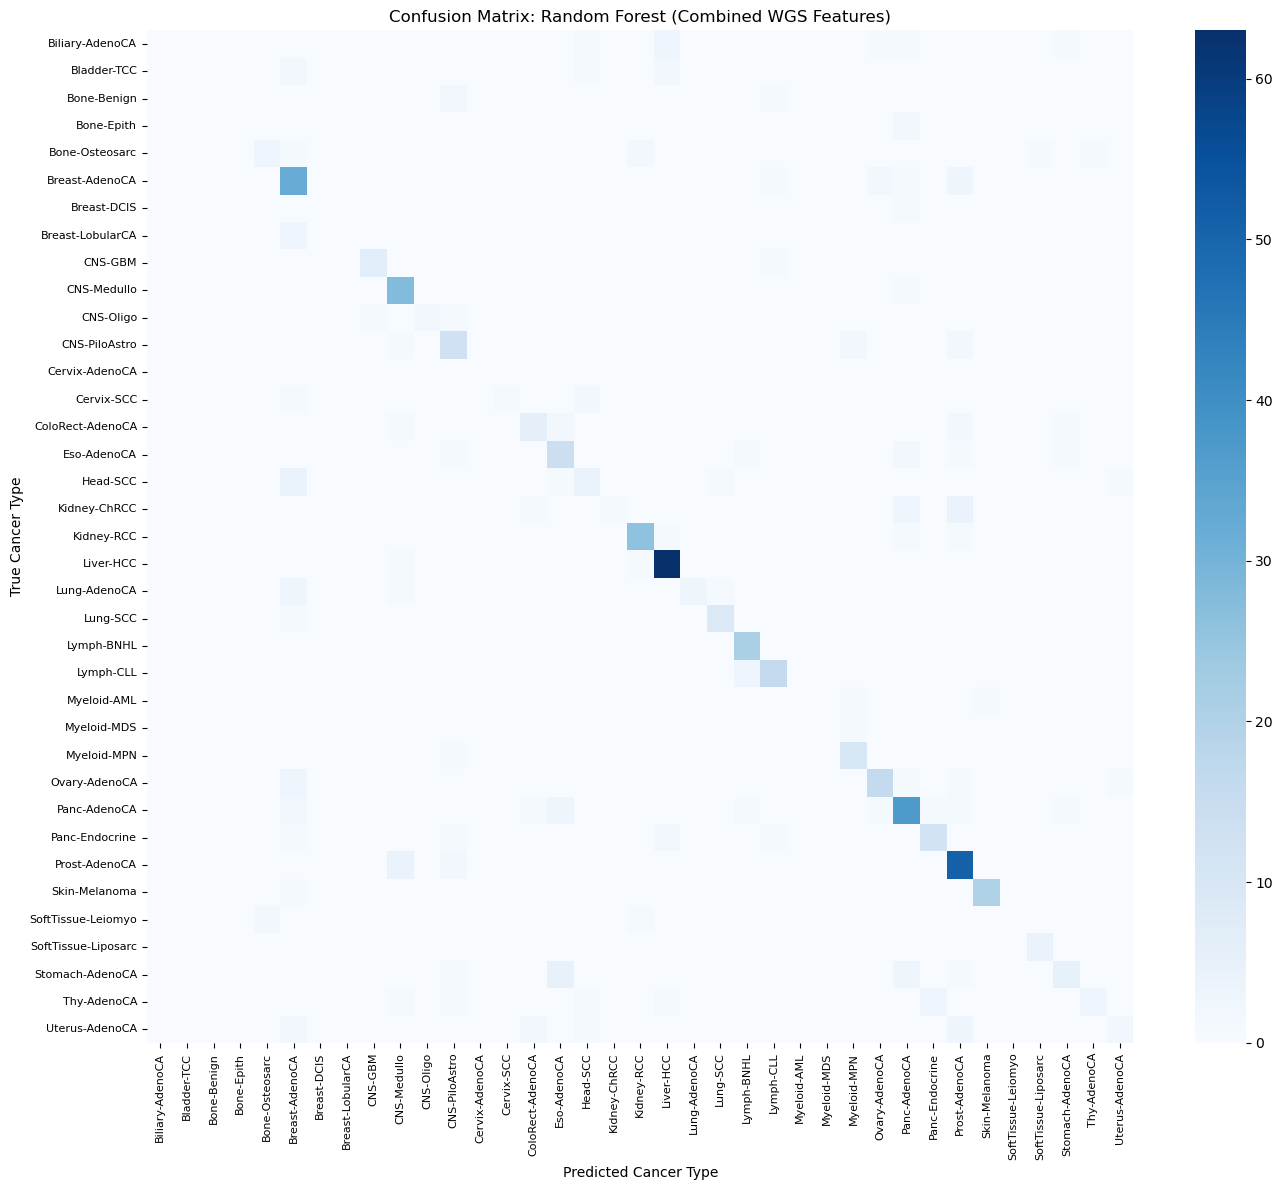


        Model Performance Summary        
                 Model  Test Accuracy
         Random Forest       0.735612
                   MLP       0.708633
Support Vector Machine       0.537770
   Logistic Regression       0.447842


In [11]:
# 1. Split the Combined WGS data
# (Assuming X_combined and y_common are already defined from the previous steps)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_common, test_size=0.2, random_state=42, stratify=y_common
)

# 2. Define an expanded dictionary of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Support Vector Machine": SVC(kernel='rbf', C=1.0, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    # Note: Gradient Boosting can be slow. If it takes too long, you can comment it out.
    #"Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

# 3. Train and evaluate models
print("================ Evaluating Expanded Models ================\n")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"accuracy": acc, "y_pred": y_pred, "model": model}
    print(f"--> {name} Test Accuracy: {acc:.4f}\n")

# 4. Find the best model
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
print(f"Best Model: {best_model_name} with {results[best_model_name]['accuracy']:.4f} Accuracy \n")

# 5. Plot Confusion Matrix for the BEST performing model
y_pred_best = results[best_model_name]['y_pred']
unique_labels = sorted(np.unique(y_common))

cm = confusion_matrix(y_test, y_pred_best, labels=unique_labels)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title(f"Confusion Matrix: {best_model_name} (Combined WGS Features)")
plt.ylabel('True Cancer Type')
plt.xlabel('Predicted Cancer Type')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# 6. Performance Summary Table
summary_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Test Accuracy": [results[m]["accuracy"] for m in results]
}).sort_values(by="Test Accuracy", ascending=False)

print("\n=========================================")
print("        Model Performance Summary        ")
print("=========================================")
print(summary_df.to_string(index=False))

In [14]:
!pip install torch -q

Data Split -> Train: 1945 | Validation: 418 | Test: 417

Starting PyTorch Training for 300 Epochs...
Epoch [25/300] | Train Loss: 0.7556, Train Acc: 0.7656 | Val Loss: 0.8191, Val Acc: 0.7919
Epoch [50/300] | Train Loss: 0.5662, Train Acc: 0.8237 | Val Loss: 0.7647, Val Acc: 0.8038
Epoch [75/300] | Train Loss: 0.5374, Train Acc: 0.8226 | Val Loss: 0.7446, Val Acc: 0.8062
Epoch [100/300] | Train Loss: 0.4750, Train Acc: 0.8468 | Val Loss: 0.8083, Val Acc: 0.7967
Epoch [125/300] | Train Loss: 0.4382, Train Acc: 0.8612 | Val Loss: 0.7523, Val Acc: 0.8158
Epoch [150/300] | Train Loss: 0.4557, Train Acc: 0.8540 | Val Loss: 0.7718, Val Acc: 0.8062
Epoch [175/300] | Train Loss: 0.4248, Train Acc: 0.8689 | Val Loss: 0.7528, Val Acc: 0.8206
Epoch [200/300] | Train Loss: 0.4527, Train Acc: 0.8602 | Val Loss: 0.7432, Val Acc: 0.8134
Epoch [225/300] | Train Loss: 0.4100, Train Acc: 0.8797 | Val Loss: 0.7839, Val Acc: 0.8110
Epoch [250/300] | Train Loss: 0.4636, Train Acc: 0.8560 | Val Loss: 0.7606

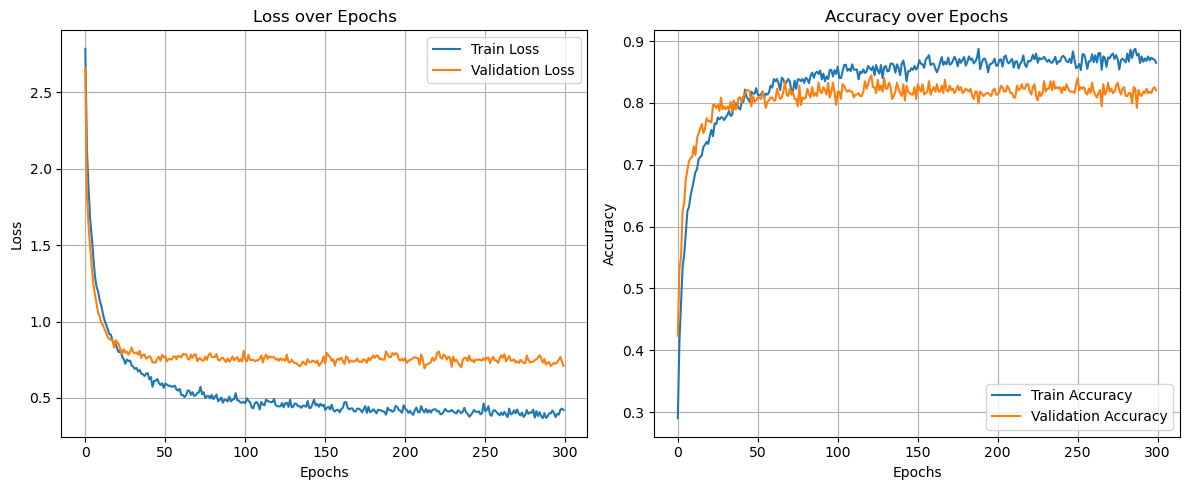

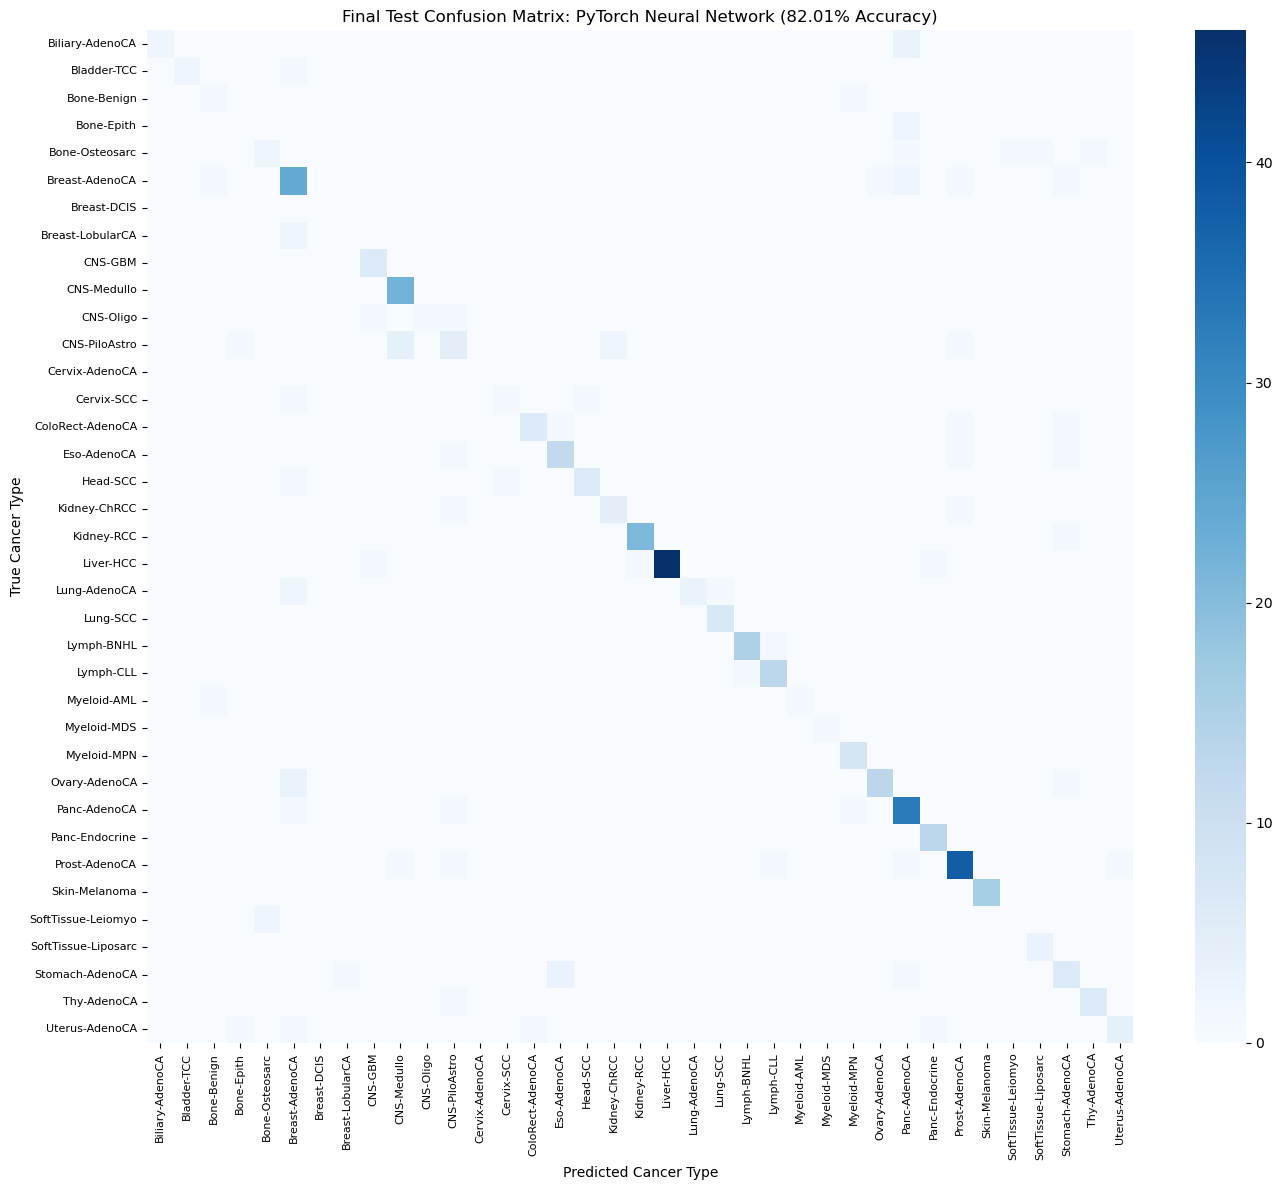

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy

# ==========================================
# 1. Train / Validation / Test Split
# ==========================================
# Assuming X_combined and y_common are available from earlier cells

# First split: Extract 15% for the FINAL TEST set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_combined, y_common, test_size=0.15, random_state=42, stratify=y_common
)

# Second split: Split the remaining 85% into Train (70%) and Validation (15%)
# 0.15 / 0.85 ≈ 0.1765
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print(f"Data Split -> Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
input_dim = X_train.shape[1]

# Convert pandas/numpy arrays to PyTorch Tensors
def create_tensor_dataset(X, y):
    X_tensor = torch.FloatTensor(X.values if hasattr(X, 'values') else X)
    y_tensor = torch.LongTensor(y)
    return TensorDataset(X_tensor, y_tensor)

train_loader = DataLoader(create_tensor_dataset(X_train, y_train_encoded), batch_size=32, shuffle=True)
val_loader = DataLoader(create_tensor_dataset(X_val, y_val_encoded), batch_size=32, shuffle=False)
test_loader = DataLoader(create_tensor_dataset(X_test, y_test_encoded), batch_size=32, shuffle=False)

# ==========================================
# 2. Define the PyTorch Neural Network
# ==========================================
class CancerClassifierNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CancerClassifierNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

model = CancerClassifierNN(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

# ==========================================
# 3. Train the Model with Validation
# ==========================================
epochs = 300
best_val_loss = float('inf')
best_model_weights = copy.deepcopy(model.state_dict())

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"\nStarting PyTorch Training for {epochs} Epochs...")

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    running_train_loss, train_correct, train_total = 0.0, 0, 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data).item()
        train_total += labels.size(0)
        
    epoch_train_loss = running_train_loss / train_total
    epoch_train_acc = train_correct / train_total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    running_val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data).item()
            val_total += labels.size(0)
            
    epoch_val_loss = running_val_loss / val_total
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    # Save best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
    
    # Print progress every 25 epochs
    if (epoch + 1) % 25 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Restore the model to the best weights found during training
model.load_state_dict(best_model_weights)
print(f"\nTraining complete. Loaded best model weights (Val Loss: {best_val_loss:.4f})")

# ==========================================
# 4. Final Evaluation on UNSEEN TEST DATA
# ==========================================
model.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.numpy())
        test_targets.extend(labels.numpy())

# Calculate Final Test Accuracy
final_test_accuracy = accuracy_score(test_targets, test_preds)
print(f"\n=========================================")
print(f" Final PyTorch Test Accuracy: {final_test_accuracy:.4f} ")
print(f"=========================================\n")

# ==========================================
# 5. Visualizations
# ==========================================
# 5A. Plot Training and Validation Curves
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 5B. Plot Final Test Confusion Matrix
decoded_preds = label_encoder.inverse_transform(test_preds)
decoded_targets = label_encoder.inverse_transform(test_targets)
unique_labels = label_encoder.classes_

cm = confusion_matrix(decoded_targets, decoded_preds, labels=unique_labels)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title(f"Final Test Confusion Matrix: PyTorch Neural Network ({final_test_accuracy:.2%} Accuracy)")
plt.ylabel('True Cancer Type')
plt.xlabel('Predicted Cancer Type')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

Removed 12 rare cancer types (< 30 samples): ['Bladder-TCC', 'SoftTissue-Liposarc', 'CNS-Oligo', 'Cervix-SCC', 'Bone-Benign', 'SoftTissue-Leiomyo', 'Breast-LobularCA', 'Myeloid-AML', 'Bone-Epith', 'Myeloid-MDS', 'Breast-DCIS', 'Cervix-AdenoCA']
Remaining: 25 cancer types, 2627 samples

Data Split -> Train: 1838 | Val: 394 | Test: 395
Input dim: 161 | Num classes: 25

Using device: cpu

Training for up to 400 epochs (early stopping patience=40)...

Ep  25 | Train 0.8324 (0.5021) | Val 0.8020 (0.8350) | LR 1.00e-03
Ep  50 | Train 0.9162 (0.2544) | Val 0.8426 (0.7571) | LR 5.00e-04

Early stopping triggered at epoch 70.

Best val loss: 0.7454 | Restored best weights.

  Final PyTorch Test Accuracy: 0.8127 (81.27%)



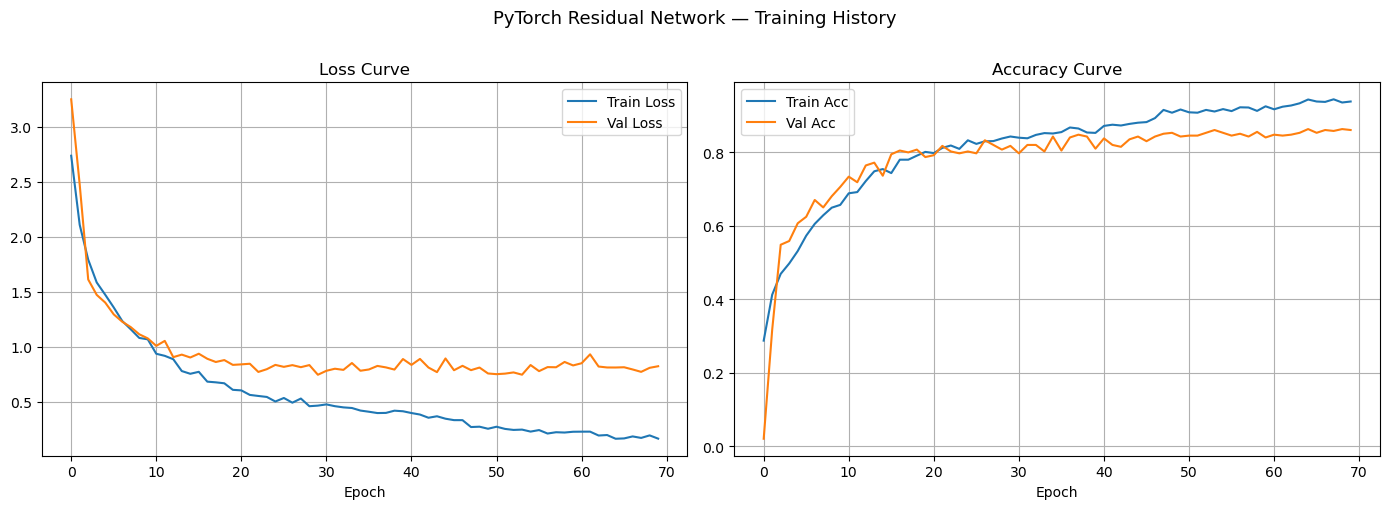

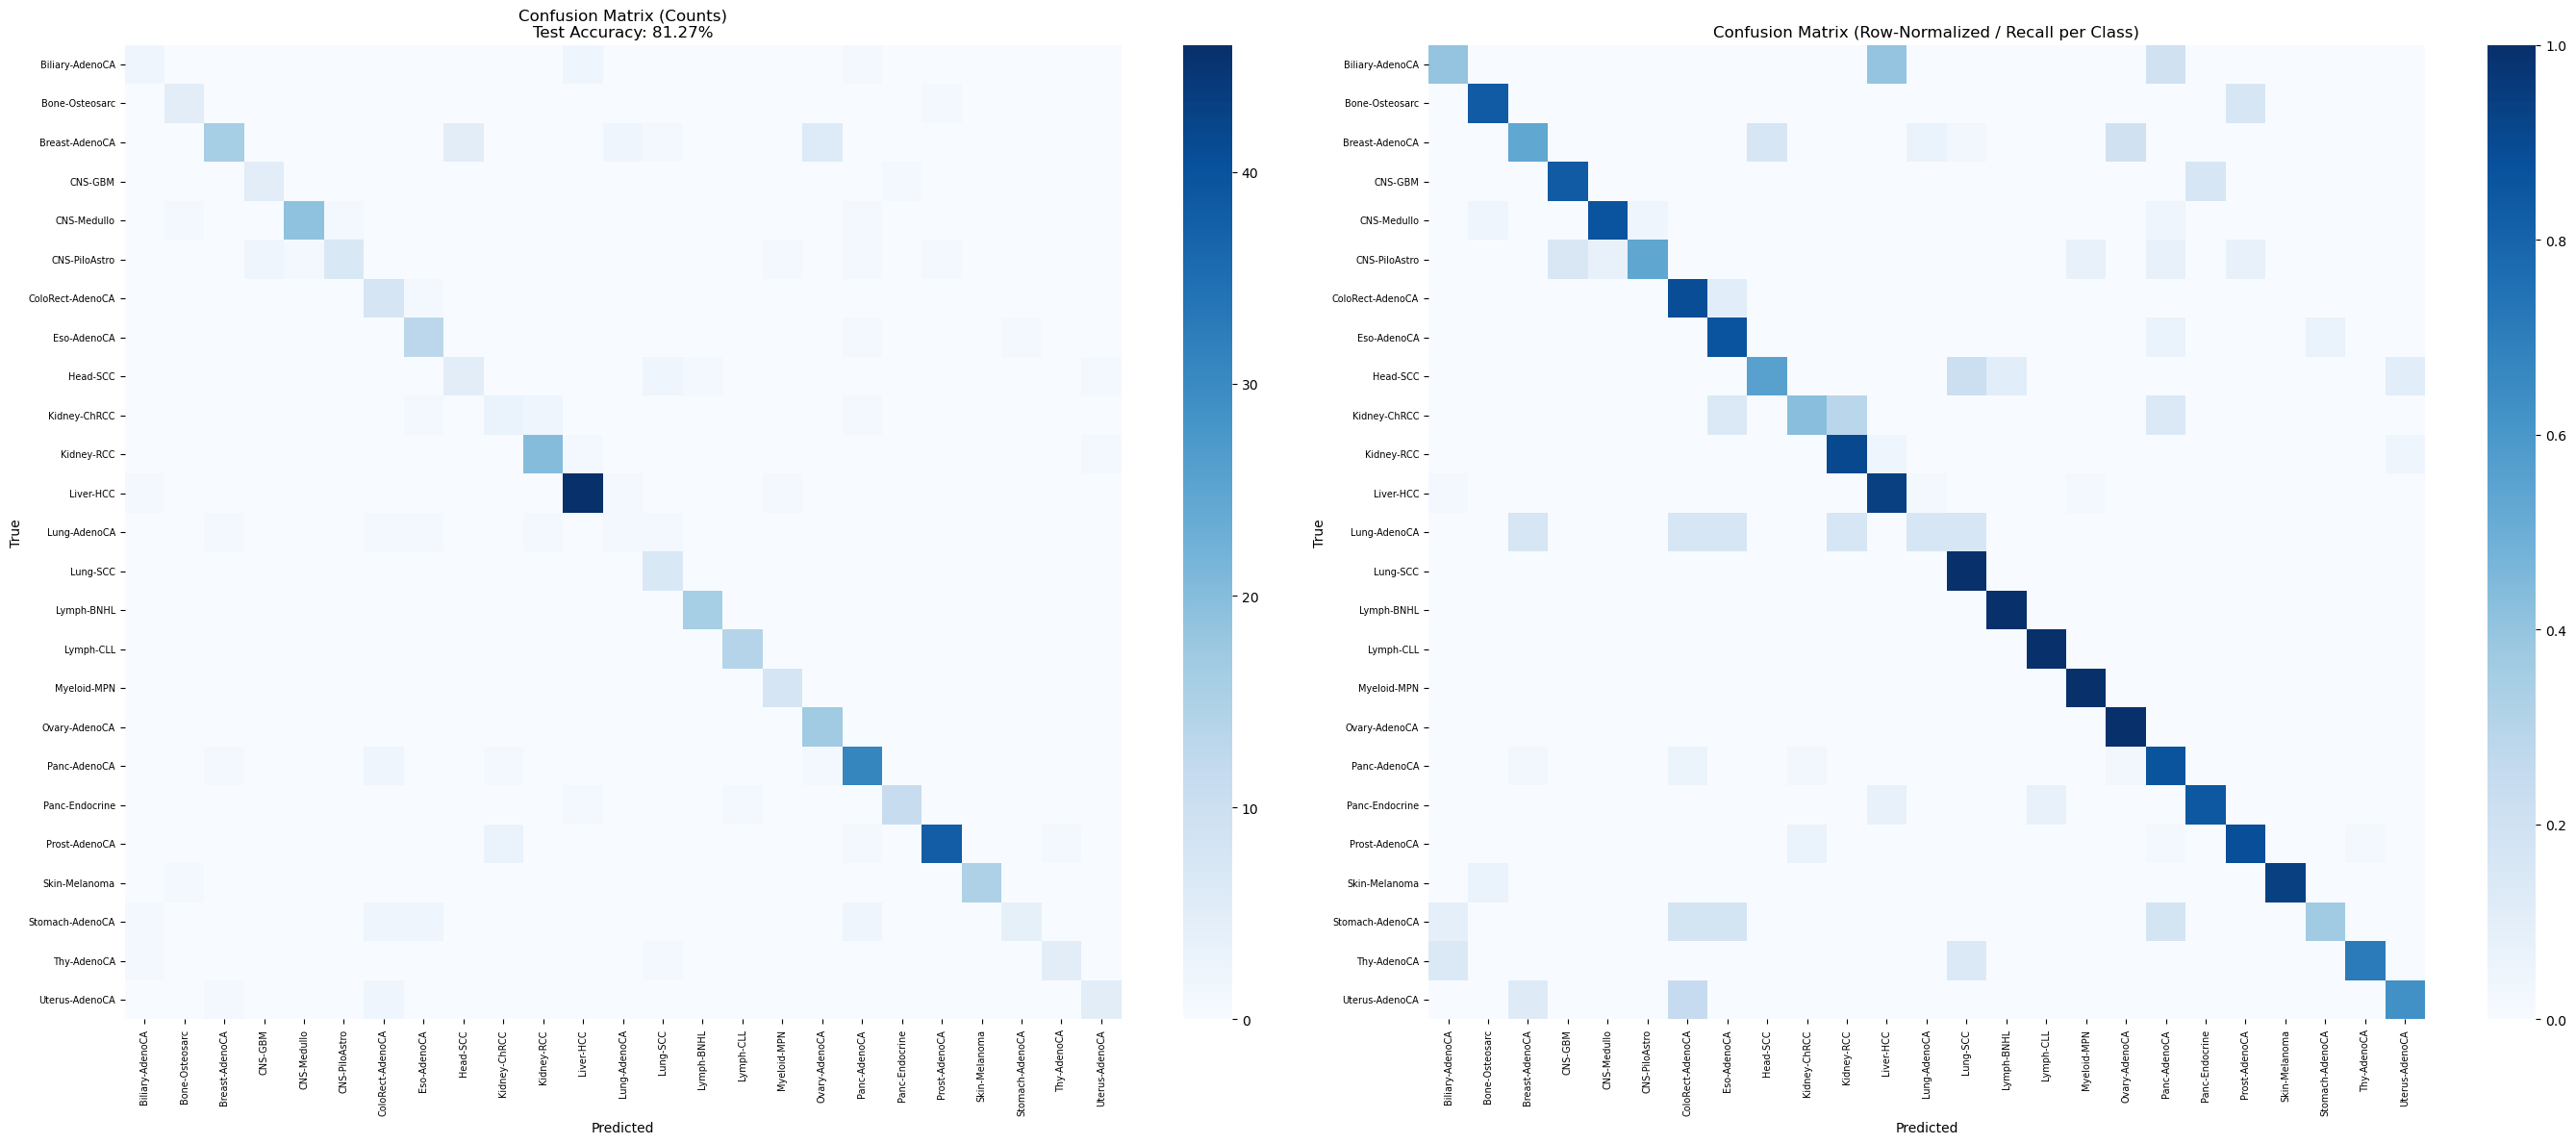

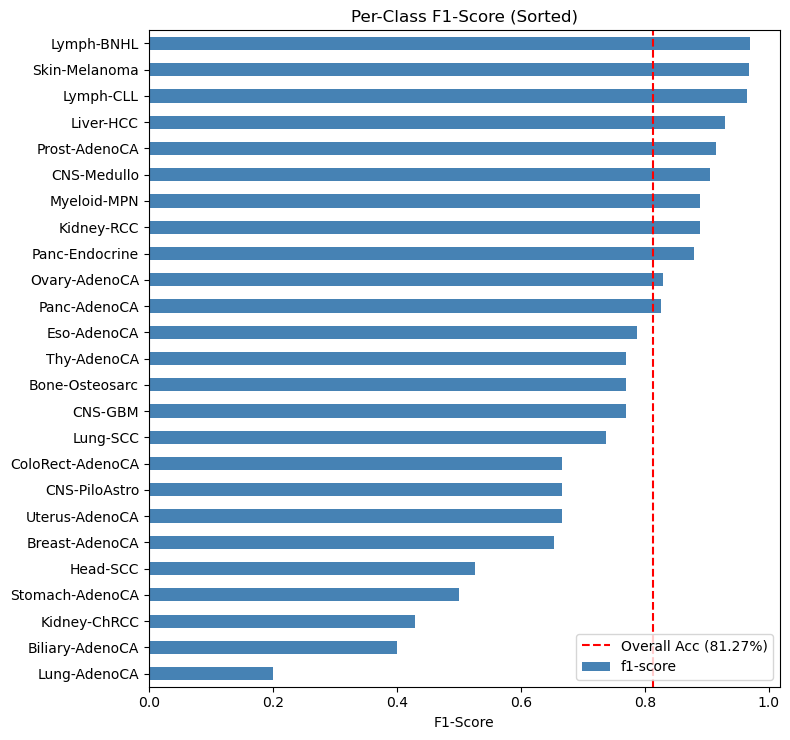


Top 5 hardest cancer types to classify:
                 precision    recall  f1-score  support
Lung-AdenoCA      0.250000  0.166667  0.200000        6
Biliary-AdenoCA   0.400000  0.400000  0.400000        5
Kidney-ChRCC      0.428571  0.428571  0.428571        7
Stomach-AdenoCA   0.800000  0.363636  0.500000       11
Head-SCC          0.500000  0.555556  0.526316        9

Top 5 easiest cancer types to classify:
               precision    recall  f1-score  support
Prost-AdenoCA   0.950000  0.883721  0.915663       43
Liver-HCC       0.920000  0.938776  0.929293       49
Lymph-CLL       0.933333  1.000000  0.965517       14
Skin-Melanoma   1.000000  0.937500  0.967742       16
Lymph-BNHL      0.941176  1.000000  0.969697       16


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy

# ==========================================
# 0. FILTER RARE CANCER TYPES
# ==========================================
MIN_SAMPLES = 30  # Minimum samples per cancer type to keep

# Count samples per cancer type
label_counts = pd.Series(y_common).value_counts()
valid_labels = label_counts[label_counts >= MIN_SAMPLES].index

# Filter combined dataset
mask = pd.Series(y_common).isin(valid_labels).values
X_filtered = X_combined[mask]
y_filtered = pd.Series(y_common)[mask]

removed = label_counts[label_counts < MIN_SAMPLES]
print(f"Removed {len(removed)} rare cancer types (< {MIN_SAMPLES} samples): {list(removed.index)}")
print(f"Remaining: {len(valid_labels)} cancer types, {len(y_filtered)} samples\n")

# ==========================================
# 1. TRAIN / VALIDATION / TEST SPLIT
# ==========================================
X_temp, X_test, y_temp, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.15, random_state=42, stratify=y_filtered
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print(f"Data Split -> Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
input_dim   = X_train.shape[1]
print(f"Input dim: {input_dim} | Num classes: {num_classes}\n")

# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y_train_enc
)
class_weights_tensor = torch.FloatTensor(class_weights)

# DataLoaders
def make_loader(X, y, batch_size=64, shuffle=True):
    X_t = torch.FloatTensor(X.values if hasattr(X, 'values') else X)
    y_t = torch.LongTensor(y)
    return DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train_enc, shuffle=True)
val_loader   = make_loader(X_val,   y_val_enc,   shuffle=False)
test_loader  = make_loader(X_test,  y_test_enc,  shuffle=False)

# ==========================================
# 2. IMPROVED ARCHITECTURE (Residual Block)
# ==========================================
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_rate=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.block(x))   # skip connection


class CancerClassifierNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        # Encoder: project input to hidden dim
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        # Stack of residual blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(512, dropout_rate=0.3),
            ResidualBlock(512, dropout_rate=0.3),
        )
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.bottleneck(x)
        return self.classifier(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model     = CancerClassifierNN(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

# Learning rate scheduler: reduce LR when val loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=15
)

# ==========================================
# 3. TRAINING WITH EARLY STOPPING
# ==========================================
EPOCHS         = 400
PATIENCE       = 40   # early stopping patience
best_val_loss  = float('inf')
best_weights   = copy.deepcopy(model.state_dict())
patience_ctr   = 0

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

print(f"\nTraining for up to {EPOCHS} epochs (early stopping patience={PATIENCE})...\n")

for epoch in range(EPOCHS):
    # --- Train ---
    model.train()
    run_loss, correct, total = 0.0, 0, 0
    for X_b, y_b in train_loader:
        X_b, y_b = X_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out  = model(X_b)
        loss = criterion(out, y_b)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        run_loss += loss.item() * X_b.size(0)
        correct  += (out.argmax(1) == y_b).sum().item()
        total    += y_b.size(0)
    t_loss, t_acc = run_loss / total, correct / total

    # --- Validate ---
    model.eval()
    run_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X_b, y_b in val_loader:
            X_b, y_b = X_b.to(device), y_b.to(device)
            out  = model(X_b)
            loss = criterion(out, y_b)
            run_loss += loss.item() * X_b.size(0)
            correct  += (out.argmax(1) == y_b).sum().item()
            total    += y_b.size(0)
    v_loss, v_acc = run_loss / total, correct / total

    train_losses.append(t_loss); val_losses.append(v_loss)
    train_accs.append(t_acc);    val_accs.append(v_acc)

    scheduler.step(v_loss)

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        best_weights  = copy.deepcopy(model.state_dict())
        patience_ctr  = 0
    else:
        patience_ctr += 1

    if (epoch + 1) % 25 == 0:
        print(f"Ep {epoch+1:3d} | Train {t_acc:.4f} ({t_loss:.4f}) | Val {v_acc:.4f} ({v_loss:.4f}) | LR {optimizer.param_groups[0]['lr']:.2e}")

    if patience_ctr >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}.")
        break

model.load_state_dict(best_weights)
print(f"\nBest val loss: {best_val_loss:.4f} | Restored best weights.")

# ==========================================
# 4. FINAL TEST EVALUATION
# ==========================================
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for X_b, y_b in test_loader:
        X_b = X_b.to(device)
        out = model(X_b)
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_targets.extend(y_b.numpy())

test_acc = accuracy_score(all_targets, all_preds)
print(f"\n{'='*45}")
print(f"  Final PyTorch Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")
print(f"{'='*45}\n")

# ==========================================
# 5. VISUALIZATIONS
# ==========================================

# 5A. Training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses,   label='Val Loss')
axes[0].set_title('Loss Curve'); axes[0].set_xlabel('Epoch'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(train_accs, label='Train Acc')
axes[1].plot(val_accs,   label='Val Acc')
axes[1].set_title('Accuracy Curve'); axes[1].set_xlabel('Epoch'); axes[1].legend(); axes[1].grid(True)
plt.suptitle('PyTorch Residual Network — Training History', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# 5B. Confusion Matrix
dec_preds   = label_encoder.inverse_transform(all_preds)
dec_targets = label_encoder.inverse_transform(all_targets)
unique_labels = label_encoder.classes_

cm = confusion_matrix(dec_targets, dec_preds, labels=unique_labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)   # row-normalize for readability

fig, axes = plt.subplots(1, 2, figsize=(28, 12))

# Raw counts
sns.heatmap(cm, ax=axes[0], annot=False, cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
axes[0].set_title(f'Confusion Matrix (Counts)\nTest Accuracy: {test_acc:.2%}')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
axes[0].tick_params(axis='x', rotation=90, labelsize=7)
axes[0].tick_params(axis='y', labelsize=7)

# Row-normalized
sns.heatmap(cm_norm, ax=axes[1], annot=False, cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels,
            vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Row-Normalized / Recall per Class)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
axes[1].tick_params(axis='x', rotation=90, labelsize=7)
axes[1].tick_params(axis='y', labelsize=7)

plt.tight_layout()
plt.show()

# 5C. Per-class F1 / Precision / Recall table
report = classification_report(
    dec_targets, dec_preds,
    labels=unique_labels,
    output_dict=True
)
report_df = (
    pd.DataFrame(report).T
    .loc[unique_labels, ['precision', 'recall', 'f1-score', 'support']]
    .sort_values('f1-score', ascending=True)
)
report_df['support'] = report_df['support'].astype(int)

fig, ax = plt.subplots(figsize=(8, max(6, len(unique_labels) * 0.3)))
report_df['f1-score'].plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('F1-Score')
ax.set_title('Per-Class F1-Score (Sorted)')
ax.axvline(x=test_acc, color='red', linestyle='--', label=f'Overall Acc ({test_acc:.2%})')
ax.legend()
plt.tight_layout()
plt.show()

print("\nTop 5 hardest cancer types to classify:")
print(report_df.head(5).to_string())
print("\nTop 5 easiest cancer types to classify:")
print(report_df.tail(5).to_string())

Remaining: 25 cancer types, 2627 samples

Device is set to: mps

  5-Fold Cross-Validation on Dev Set
  Fold 1: Val Accuracy = 0.8389
  Fold 2: Val Accuracy = 0.8412
  Fold 3: Val Accuracy = 0.8184
  Fold 4: Val Accuracy = 0.8520
  Fold 5: Val Accuracy = 0.8139

  CV Mean ± Std: 0.8329 ± 0.0144

  Ensemble Test Accuracy (5 folds): 0.8734 (87.34%)



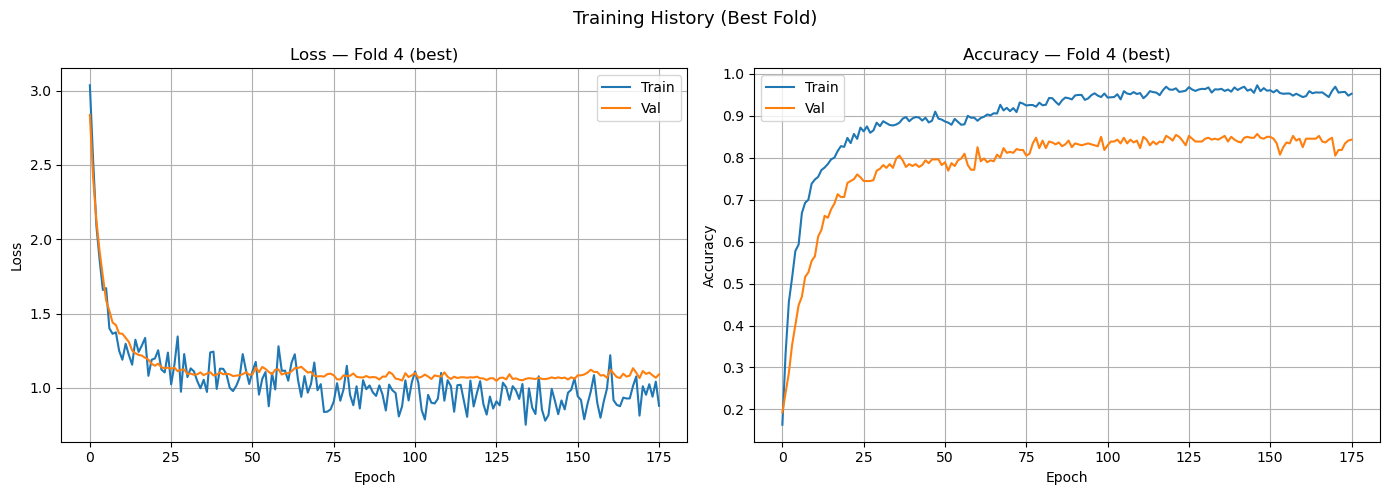

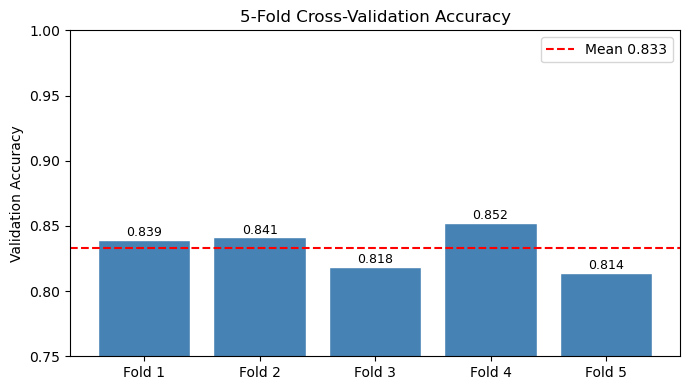

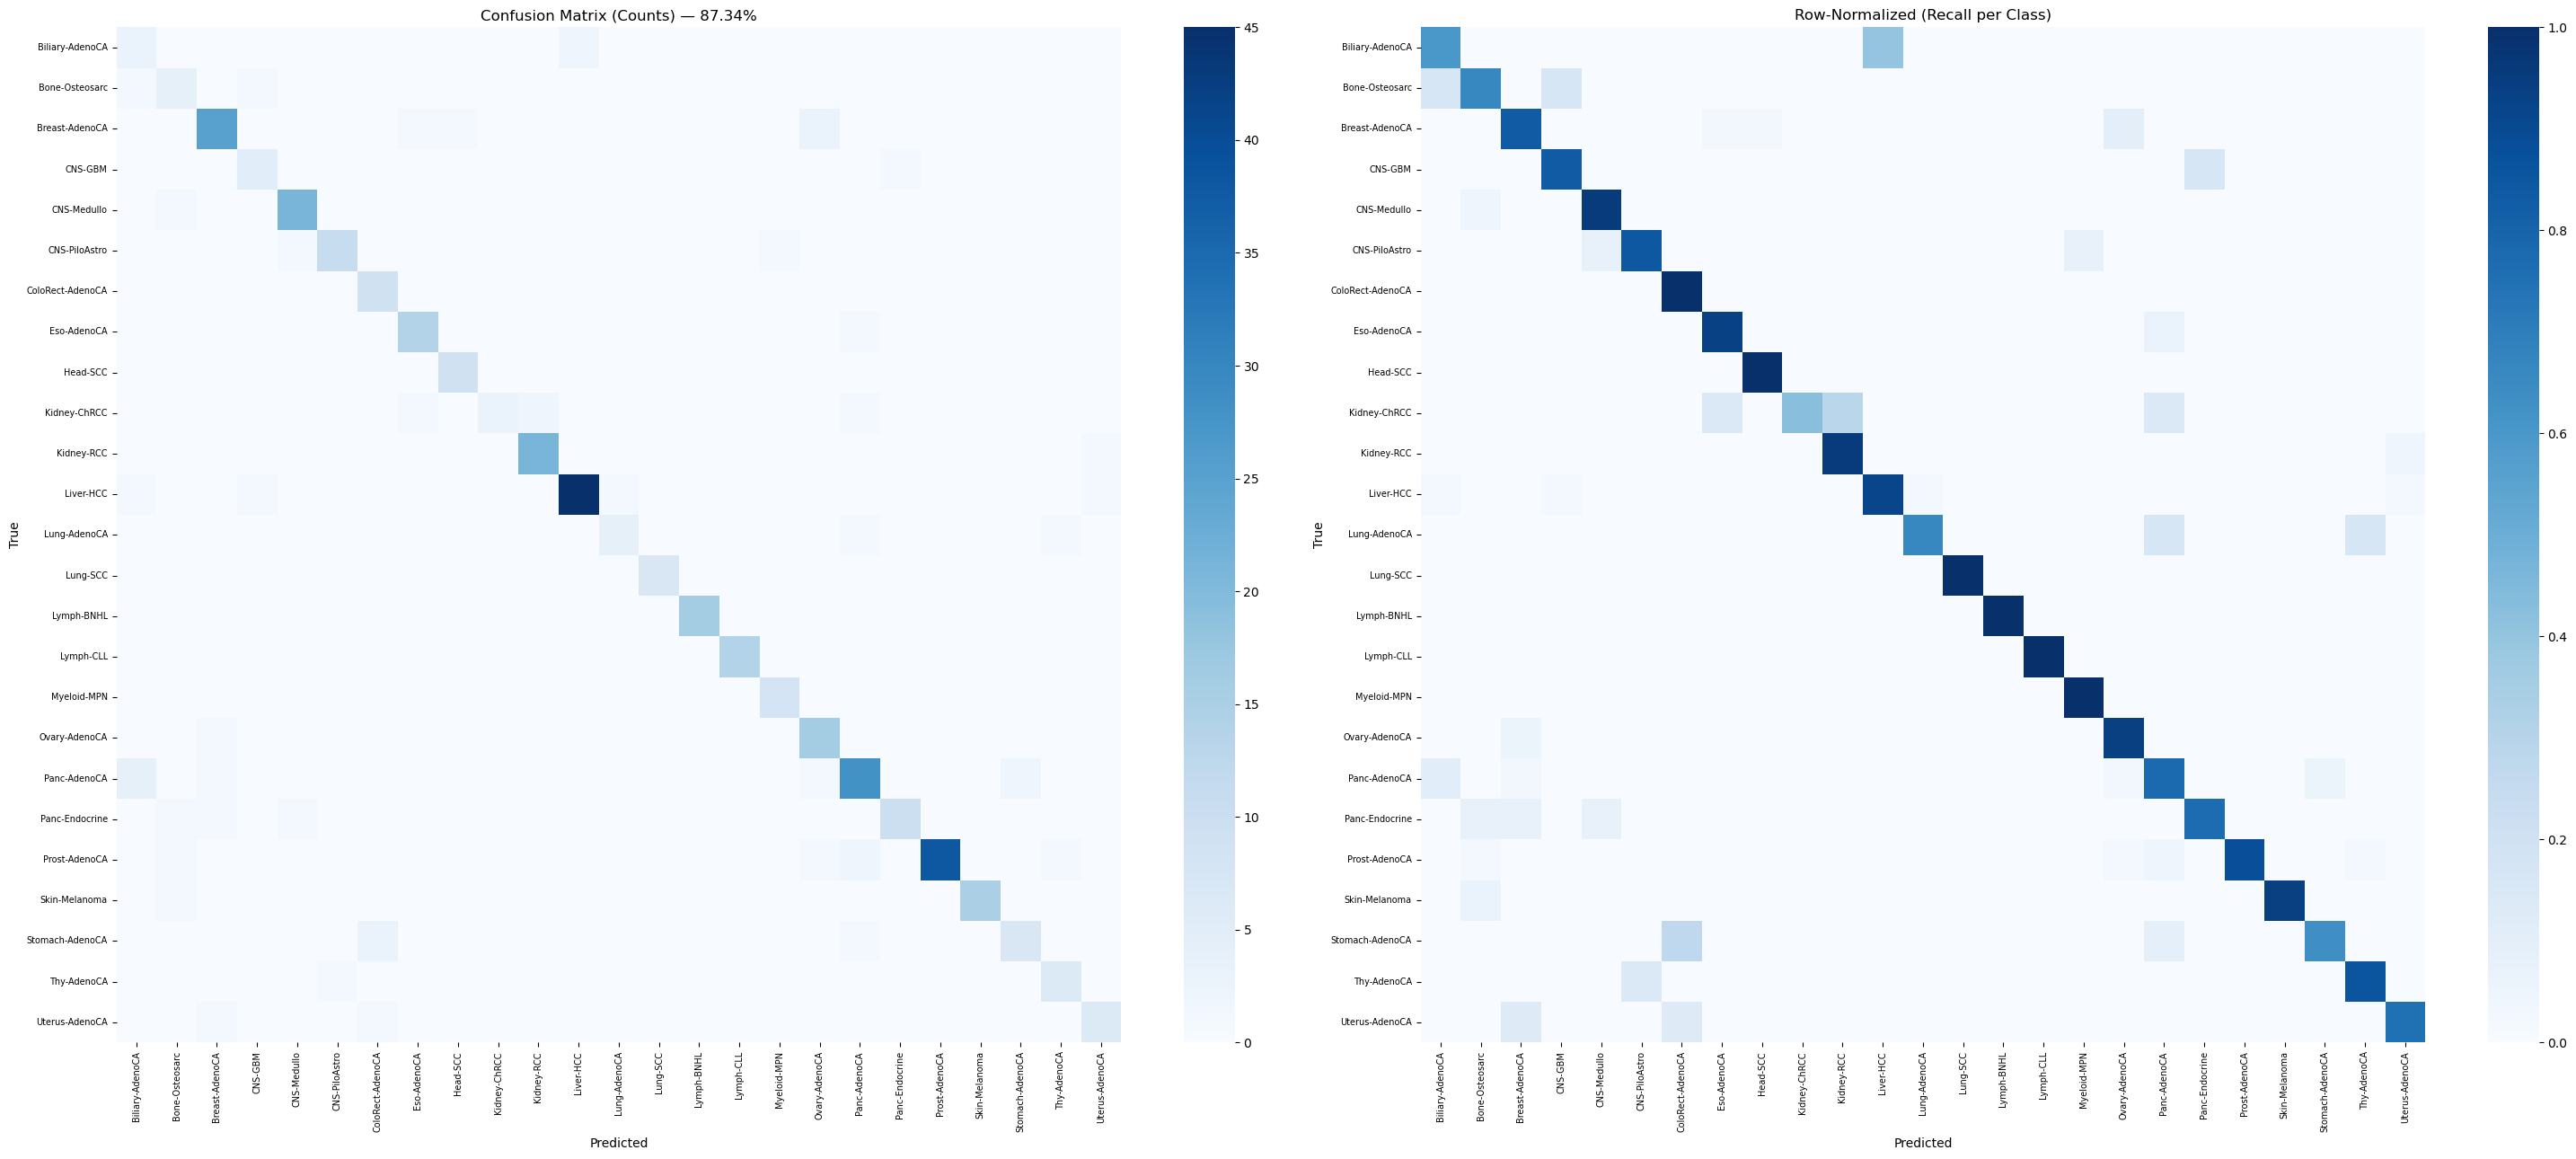

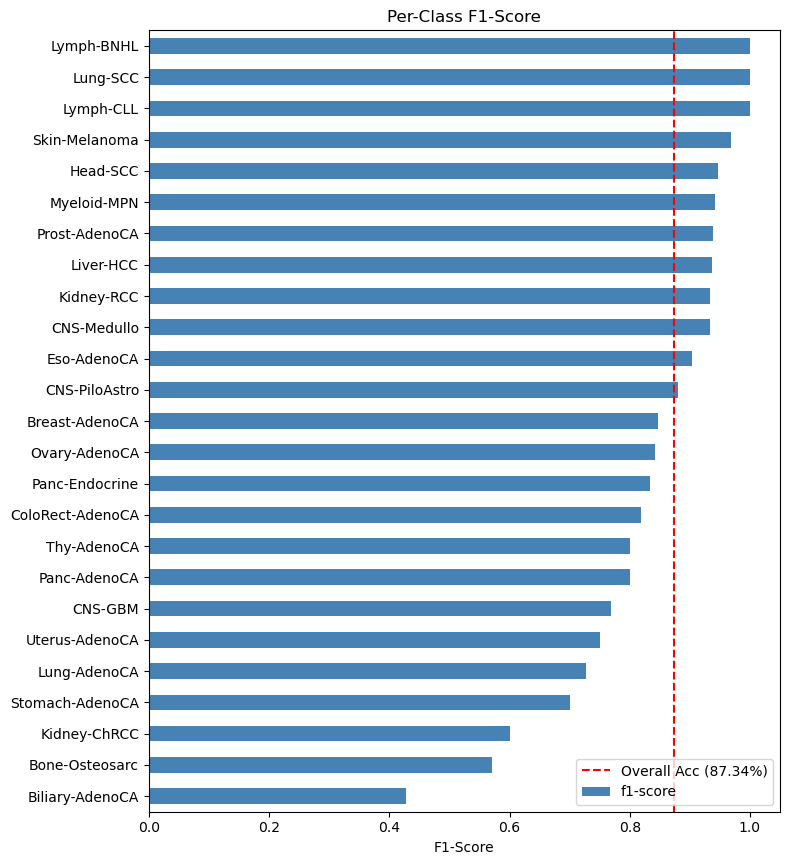


── 5 hardest cancer types ──
                 precision    recall  f1-score  support
Biliary-AdenoCA   0.333333  0.600000  0.428571        5
Bone-Osteosarc    0.500000  0.666667  0.571429        6
Kidney-ChRCC      1.000000  0.428571  0.600000        7
Stomach-AdenoCA   0.777778  0.636364  0.700000       11
Lung-AdenoCA      0.800000  0.666667  0.727273        6

── 5 easiest cancer types ──
               precision  recall  f1-score  support
Head-SCC             0.9  1.0000  0.947368        9
Skin-Melanoma        1.0  0.9375  0.967742       16
Lymph-CLL            1.0  1.0000  1.000000       14
Lung-SCC             1.0  1.0000  1.000000        7
Lymph-BNHL           1.0  1.0000  1.000000       16


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy

def select_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

# ==========================================
# 0. FILTER RARE CANCER TYPES
# ==========================================
MIN_SAMPLES = 30  # Minimum samples per cancer type to keep

label_counts = pd.Series(y_common).value_counts()
valid_labels  = label_counts[label_counts >= MIN_SAMPLES].index
mask          = pd.Series(y_common).isin(valid_labels).values
X_filtered    = X_combined[mask]
y_filtered    = pd.Series(y_common)[mask].reset_index(drop=True)

print(f"Remaining: {len(valid_labels)} cancer types, {len(y_filtered)} samples\n")
print(f"Device is set to: {select_device()}\n")

# ==========================================
# 1. FEATURE SCALING  (critical for NNs!)
# ==========================================
# Profiles are already normalized to sum=1, but activities vary widely.
# StandardScaler brings all 161 features to zero-mean / unit-variance.
scaler   = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_filtered),
    index=X_filtered.index,
    columns=X_filtered.columns
)

# ==========================================
# 2. LABEL ENCODING
# ==========================================
label_encoder = LabelEncoder()
y_encoded     = label_encoder.fit_transform(y_filtered)
num_classes   = len(label_encoder.classes_)
input_dim     = X_scaled.shape[1]

# ==========================================
# 3. HOLD-OUT TEST SET  (stratified 15%)
# ==========================================
X_dev, X_test, y_dev, y_test = train_test_split(
    X_scaled.values, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

# ==========================================
# 4. MIXUP DATA AUGMENTATION
# ==========================================
def mixup_batch(X, y, alpha=0.3):
    """Returns a mixed batch — interpolates between two random samples."""
    lam   = np.random.beta(alpha, alpha)
    idx   = torch.randperm(X.size(0))
    X_mix = lam * X + (1 - lam) * X[idx]
    y_a, y_b = y, y[idx]
    return X_mix, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ==========================================
# 5. ARCHITECTURE  (lighter + more dropout)
# ==========================================
class ResBlock(nn.Module):
    def __init__(self, dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim), nn.BatchNorm1d(dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(dim, dim), nn.BatchNorm1d(dim),
        )
        self.act = nn.GELU()
    def forward(self, x):
        return self.act(x + self.net(x))

class CancerNet(nn.Module):
    def __init__(self, input_size, num_classes, hidden=256, dropout=0.4):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Linear(input_size, hidden), nn.BatchNorm1d(hidden), nn.GELU(), nn.Dropout(dropout)
        )
        self.blocks = nn.Sequential(
            ResBlock(hidden, dropout=0.3),
            ResBlock(hidden, dropout=0.3),
            ResBlock(hidden, dropout=0.3),
        )
        self.head = nn.Sequential(
            nn.Linear(hidden, 128), nn.BatchNorm1d(128), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.head(self.blocks(self.stem(x)))

# ==========================================
# 6. TRAIN ONE FOLD  (reusable function)
# ==========================================
def train_fold(X_tr, y_tr, X_vl, y_vl, epochs=500, patience=50, lr=5e-4):
    device = select_device()

    # Weighted sampler so every class appears equally in each mini-batch
    class_counts = np.bincount(y_tr)
    sample_weights = 1.0 / class_counts[y_tr]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    def loader(X, y, sampler=None, bs=64):
        ds = TensorDataset(torch.FloatTensor(X), torch.LongTensor(y))
        return DataLoader(ds, batch_size=bs, sampler=sampler,
                          shuffle=(sampler is None))

    tr_loader = loader(X_tr, y_tr, sampler=sampler)
    vl_loader = loader(X_vl, y_vl, bs=128)

    # Class weights for loss (belt + suspenders approach)
    cw = compute_class_weight('balanced', classes=np.arange(num_classes), y=y_tr)
    cw_t = torch.FloatTensor(cw).to(device)

    net       = CancerNet(input_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=cw_t, label_smoothing=0.05)
    opt       = optim.AdamW(net.parameters(), lr=lr, weight_decay=5e-4)
    sched     = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=50, T_mult=2)

    best_loss, best_w, patience_ctr = float('inf'), None, 0
    history = {'tl': [], 'vl': [], 'ta': [], 'va': []}

    for ep in range(epochs):
        # --- Train ---
        net.train()
        tl, tc, tt = 0, 0, 0
        for Xb, yb in tr_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            Xm, ya, yb2, lam = mixup_batch(Xb, yb, alpha=0.3)
            opt.zero_grad()
            out  = net(Xm)
            loss = mixup_criterion(criterion, out, ya, yb2, lam)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
            # Accuracy on un-mixed batch for monitoring
            with torch.no_grad():
                tc += (net(Xb).argmax(1) == yb).sum().item()
            tt += Xb.size(0)
        sched.step()

        # --- Validate ---
        net.eval()
        vl, vc, vt = 0, 0, 0
        with torch.no_grad():
            for Xb, yb in vl_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out  = net(Xb)
                loss = criterion(out, yb)
                vl += loss.item() * Xb.size(0)
                vc += (out.argmax(1) == yb).sum().item()
                vt += Xb.size(0)

        tl /= tt; vl /= vt
        history['tl'].append(tl); history['vl'].append(vl)
        history['ta'].append(tc/tt); history['va'].append(vc/vt)

        if vl < best_loss:
            best_loss, best_w, patience_ctr = vl, copy.deepcopy(net.state_dict()), 0
        else:
            patience_ctr += 1
        if patience_ctr >= patience:
            break

    net.load_state_dict(best_w)
    return net, history

# ==========================================
# 7. 5-FOLD CROSS-VALIDATION  (robust eval)
# ==========================================
N_FOLDS  = 5
skf      = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
fold_nets = []
fold_accs = []

print("=" * 55)
print("  5-Fold Cross-Validation on Dev Set")
print("=" * 55)

all_histories = []
for fold, (tr_idx, vl_idx) in enumerate(skf.split(X_dev, y_dev)):
    X_tr, y_tr = X_dev[tr_idx], y_dev[tr_idx]
    X_vl, y_vl = X_dev[vl_idx], y_dev[vl_idx]

    net, hist = train_fold(X_tr, y_tr, X_vl, y_vl, epochs=500, patience=50)
    fold_nets.append(net)
    all_histories.append(hist)

    # Fold accuracy
    device = select_device()
    net.eval()
    with torch.no_grad():
        out = net(torch.FloatTensor(X_vl).to(device))
        preds = out.argmax(1).cpu().numpy()
    acc = accuracy_score(y_vl, preds)
    fold_accs.append(acc)
    print(f"  Fold {fold+1}: Val Accuracy = {acc:.4f}")

print(f"\n  CV Mean ± Std: {np.mean(fold_accs):.4f} ± {np.std(fold_accs):.4f}\n")

# ==========================================
# 8. ENSEMBLE PREDICTION ON TEST SET
#    (average softmax probabilities across folds)
# ==========================================
device = select_device()
X_test_t = torch.FloatTensor(X_test).to(device)

probs_list = []
for net in fold_nets:
    net.eval()
    with torch.no_grad():
        logits = net(X_test_t)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
    probs_list.append(probs)

# Average ensemble
ensemble_probs = np.mean(probs_list, axis=0)
ensemble_preds = ensemble_probs.argmax(axis=1)

test_acc = accuracy_score(y_test, ensemble_preds)
print(f"{'='*55}")
print(f"  Ensemble Test Accuracy ({N_FOLDS} folds): {test_acc:.4f} ({test_acc:.2%})")
print(f"{'='*55}\n")

# ==========================================
# 9. VISUALIZATIONS
# ==========================================

# 9A. Training curves — best fold (highest val acc)
best_fold_idx = int(np.argmax(fold_accs))
hist = all_histories[best_fold_idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(hist['tl'], label='Train'); axes[0].plot(hist['vl'], label='Val')
axes[0].set_title(f'Loss — Fold {best_fold_idx+1} (best)')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(hist['ta'], label='Train'); axes[1].plot(hist['va'], label='Val')
axes[1].set_title(f'Accuracy — Fold {best_fold_idx+1} (best)')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy'); axes[1].legend(); axes[1].grid(True)
plt.suptitle('Training History (Best Fold)', fontsize=13)
plt.tight_layout(); plt.show()

# 9B. CV fold accuracy bar chart
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar([f'Fold {i+1}' for i in range(N_FOLDS)], fold_accs, color='steelblue', edgecolor='white')
ax.axhline(np.mean(fold_accs), color='red', linestyle='--', label=f'Mean {np.mean(fold_accs):.3f}')
ax.set_ylim(0.75, 1.0); ax.set_ylabel('Validation Accuracy')
ax.set_title('5-Fold Cross-Validation Accuracy'); ax.legend()
for b, v in zip(bars, fold_accs):
    ax.text(b.get_x() + b.get_width()/2, v + 0.003, f'{v:.3f}', ha='center', fontsize=9)
plt.tight_layout(); plt.show()

# 9C. Confusion matrices (counts + row-normalised)
dec_preds   = label_encoder.inverse_transform(ensemble_preds)
dec_targets = label_encoder.inverse_transform(y_test)
unique_labels = label_encoder.classes_

cm      = confusion_matrix(dec_targets, dec_preds, labels=unique_labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(30, 13))
sns.heatmap(cm, ax=axes[0], annot=False, cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
axes[0].set_title(f'Confusion Matrix (Counts) — {test_acc:.2%}')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
axes[0].tick_params(axis='x', rotation=90, labelsize=7)
axes[0].tick_params(axis='y', labelsize=7)

sns.heatmap(cm_norm, ax=axes[1], annot=False, cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels, vmin=0, vmax=1)
axes[1].set_title('Row-Normalized (Recall per Class)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
axes[1].tick_params(axis='x', rotation=90, labelsize=7)
axes[1].tick_params(axis='y', labelsize=7)
plt.tight_layout(); plt.show()

# 9D. Per-class F1 bar chart
report    = classification_report(dec_targets, dec_preds, labels=unique_labels, output_dict=True)
report_df = (
    pd.DataFrame(report).T
    .loc[unique_labels, ['precision', 'recall', 'f1-score', 'support']]
    .sort_values('f1-score', ascending=True)
)
report_df['support'] = report_df['support'].astype(int)

fig, ax = plt.subplots(figsize=(8, max(6, len(unique_labels) * 0.35)))
report_df['f1-score'].plot(kind='barh', ax=ax, color='steelblue')
ax.axvline(test_acc, color='red', linestyle='--', label=f'Overall Acc ({test_acc:.2%})')
ax.set_xlabel('F1-Score'); ax.set_title('Per-Class F1-Score'); ax.legend()
plt.tight_layout(); plt.show()

print("\n── 5 hardest cancer types ──")
print(report_df.head(5)[['precision','recall','f1-score','support']].to_string())
print("\n── 5 easiest cancer types ──")
print(report_df.tail(5)[['precision','recall','f1-score','support']].to_string())